<a href="https://colab.research.google.com/github/ChJazhiel/HPC_II/blob/main/Taller%20GANs/DCGAN_Simpson_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio
## Generación de personajes de los Simpson con una DCGAN  

**Dataset**  
El conjunto de datos original se puede encontrar en [https://www.kaggle.com/datasets/kostastokis/simpsons-faces](https://www.kaggle.com/datasets/kostastokis/simpsons-faces)  
El archivo consta de 9877 imágenes de 200x200 pixeles de rostros de personajes de los Simpson
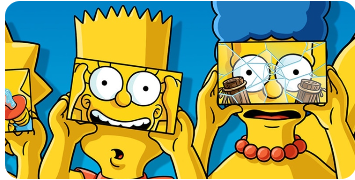

El siguiente ejercicio utiliza una versión reducida del conjunto de datos

In [1]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2
import imageio
import glob
import zipfile
from PIL import Image
from pathlib import Path
from IPython import display
from tqdm.auto import tqdm # Loading bar

# Importar paquetes de pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Importar paquetes de  torchvision packages
from torchvision import datasets
from torchvision import transforms

## 1. Descargar y visualizar el conjunto de datos  
1. Descargar el archivo `simpson.zip` del siguiente repositorio [https://github.com/ChJazhiel/HPC_II/blob/main/Taller%20GANs/simpson.zip](https://github.com/ChJazhiel/HPC_II/blob/main/Taller%20GANs/simpson.zip)
2. Subir el archivo a google colab
3. Unzip el archivo
4. Visualizar imágenes

In [2]:
# Subir archivos a google Colab
from google.colab import files
files.upload()

Saving simpson.zip to simpson.zip


In [ ]:
# Unzip folder
!unzip -q simpson.zip

In [4]:
# Ruta de las imágenes
image_path = "/content/simpson/"

In [5]:
# Obtener lista de imágenes en la carpeta
images = Path(image_path).glob("*.png")
image_strings = [str(p) for p in images]
print(f"Número de imágenes en la carpeta: {len(image_strings)}")

Número de imágenes en la carpeta: 577


Ruta de la imagen aleatoria: /content/simpson/2443.png
Tamaño de la imagen: 200 x 200
Número de canales: ('R', 'G', 'B')


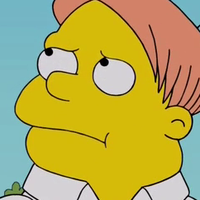

In [6]:
# Selección de una imagen aleatoria de la carpeta y visualizarla
random_image_path = random.choice(image_strings)
img = Image.open(random_image_path)

# Desplegar Metadata y visualizar imagen
print(f"Ruta de la imagen aleatoria: {random_image_path}")
print(f"Tamaño de la imagen: {img.height} x {img.width}")
print(f"Número de canales: {img.getbands()}")
img

## 2. Cargar conjunto de datos en el formato de PyTorch  

#### Transformación de las imágenes  
✍  
Utilizar `transforms.Compose` para
- Modificar el tamaño de la imagen de 200x200 pixeles a 64x64.
- Transformar la imagen PIL a un tensor  

*Pista:* Utilizar `transform.Resize(size=)` para modificar el tamaño de la imagen  y `transform.ToTensor()` para convertir la imagen a un tensor    

In [7]:
# Escribir las transformaciones para preparar a las imágenes
data_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                    transforms.ToTensor()])

Información de las imágenes
-----------------------------------------------------------
Tamaño de la imagen original: (200, 200, 3)
Rango[min:0, max: 248]
-----------------------------------------------------------
Tamaño de la imagen transformada: torch.Size([64, 64, 3])
Rango[min: 0.0117647061124444, max: 0.8705882430076599]




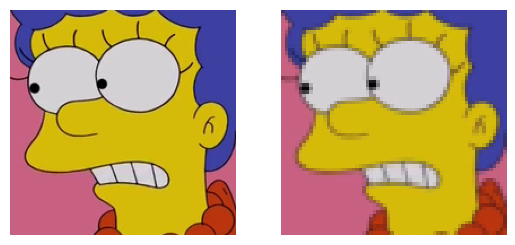

In [8]:
# Selección de una imagen aleatoria de la carpeta
random_image_path = random.choice(image_strings)
img = Image.open(random_image_path)
# Transformación de la imagen
transformed_image = data_transform(img).permute(1, 2, 0) # Para visualizar la imagen,se modifica el tensor con forma (C,H,W) a (H,W,C)

## Información de las imágenes
print("Información de las imágenes")
print("-----------------------------------------------------------")
## ------ Imágen original ------
arr_img = np.asarray(img)
print(f"Tamaño de la imagen original: {arr_img.shape}")
print(f"Rango[min:{arr_img.min()}, max: {arr_img.max()}]")
print("-----------------------------------------------------------")
## ------ Imágen transformada ------
print(f"Tamaño de la imagen transformada: {transformed_image.shape}")
print(f"Rango[min: {transformed_image.min()}, max: {transformed_image.max()}]")
print("\n")

# Visualizar imagen original y tranformación
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis("off")

ax[1].imshow(transformed_image)
ax[1].axis("off")
plt.show()

#### Cagar el conjunto de datos con la clase Dataset  

La clase `Dataset` permite cargar los conjuntos de datos propios pues almacena las imágenes y sus etiquetas correspondientes.  
Para cargar un conjunto de datos se debe implementar tres funciones en la clase:

*  `__init__` La función __init__ se ejecuta una vez al instanciar el objeto *Dataset*. Se inicializa con el directorio que contiene las imágenes y transformaciones.
*  `__len__` La función __len__ regresa el número de muestras en el conjunto de datos.
*  `__getitem__` La función __getitem__ carga y regresa una muestra del conjunto de datos dado un determinado índice *idx*

**Referencia:** [https://pytorch.org/tutorials/beginner/basics/data_tutorial.html](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [9]:
class CustomDataset(Dataset):
    def __init__(self,img_path,transform=None):
        self.img_path = img_path
        self.data = glob.glob(self.img_path + "*")
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_path = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image

In [10]:
train_dataset = CustomDataset(image_path, transform=data_transform)
print(f"Tamaño del Dataset: {len(train_dataset)}")

Tamaño del Dataset: 577


## 3. Preparar los datos para el entrenamiento con DataLoaders  

✍   
Agregar los siguientes argumentos en la clase `DataLoader`:

*   `dataset` Conjunto de datos.  
*   `batch_size` Tamaño de las muestras contenidas en cada batch
*   `shuffle` Establecer a shuffle como verdadero (*True*)

In [11]:
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = train_dataset,
                               batch_size = BATCH_SIZE,
                               shuffle = True)

In [12]:
print(f"Número de batches en el train loader: {len(train_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 10 batches de 64 imágenes cada uno


In [13]:
# Verificar que hay dentro del DataLoader
train_batches = next(iter(train_dataloader))
print(train_batches.shape)

torch.Size([64, 3, 64, 64])


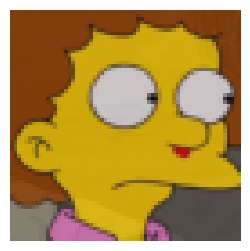

In [14]:
# Visualizar una imagen aleatoria del batch
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

In [15]:
# Configuración de CPU o GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## 4. Definir modelos

#### Discriminador

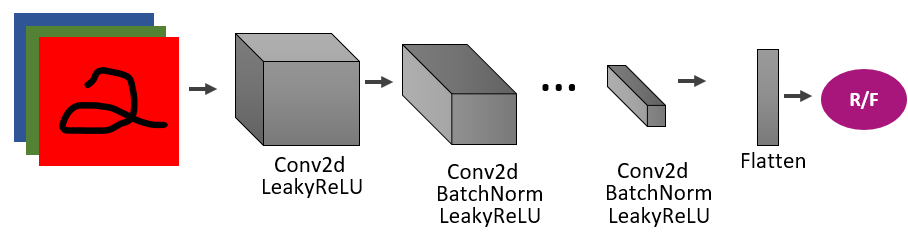


✍  
Definir la arquitectura del discriminador convolucional.   
**Entrada y Salida**
- La entrada del discriminador es una imagen de (num_batches,3,64,64).
- La salida es un valor de probabilidad.  

**Arquitectura**  
- Utilizar capas convolucionales `Conv2d` con `strides=2` en lugar de capas `MaxPooling` para reducir el tamaño de la imagen.
- Utilizar `BatchNorm2d` en todas las capas del discriminador excepto en la entrada del discriminador.
- Utilizar la función de activación `LeakyReLU` con una pendiente de **0.2** en las capas intermedias exepto en la salida.
- Utilizar la función de activación `Sigmoid` en la salida para regresar valores en el rango de  0 y 1.   

In [16]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self, channels_img, hidden_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=channels_img, out_channels=hidden_units, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [17]:
# Configurar el modelo con los parámetros de entrada
discriminator = Discriminator(channels_img=3, hidden_units=64)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16384, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [18]:
# Probar discriminador con entrada dummy
dummy_x = torch.rand([1,3,64,64]).to(device)
print(f"Tamaño del vector de entrada del discriminador: {dummy_x.size()}")

dummy_out = discriminator(dummy_x).detach()
print(f"Salida del discriminador: {dummy_out}")

Tamaño del vector de entrada del discriminador: torch.Size([1, 3, 64, 64])
Salida del discriminador: tensor([[0.4760]], device='cuda:0')


#### Generador

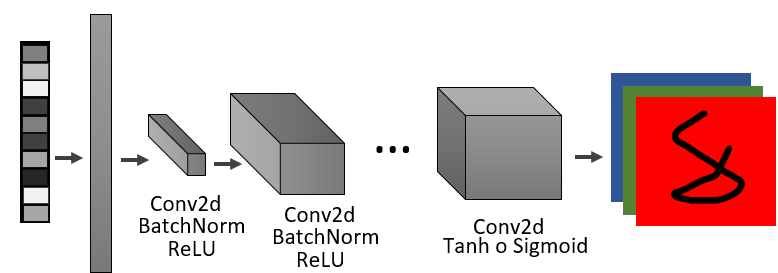

✍  
Definir la arquitectura del generador.   
**Entrada y Salida**
- La entrada del generador es un vector de ruido aleatorio de la forma (num_batches,LATENT_DIM).
- La salida es una imagen de tamaño (num_batches,3,64,64).  

**Arquitectura**  
- Utilizar una capa completamente conectada `Linear` para reestructurar el vector de ruido.
- Utilizar capas convolucionales transpuestas `ConvTranspose2d` con `strides=2` para aumentar el tamaño de la imagen.
- Utilizar `BatchNorm2d` en todas las capas del generador excepto en la salida.
- Utilizar la función de activación `ReLU` en las capas intermedias exepto en la salida.
- Utilizar la función de activación `Sigmoid` en la salida para regresar valores en el rango de  [0, 1] o `Tanh` si las entradas estan en el rango de [-1,1].  

In [19]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        self.block1 = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=16*16*hidden_units*4))
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_units*4, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units, out_channels=3,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.block1(x)
        # reshape from flatten
        x = torch.reshape(x, (-1, self.hidden_units*4,16,16))
        x = self.block2(x)
        return x

✍  
Agregar dimensión al vector en el espacio de latencia (`LATENT_DIM`)

In [20]:
LATENT_DIM = 128

In [21]:
# Configurar el modelo con los parámetros de entrada
generator = Generator(latent_dim=LATENT_DIM, hidden_units=64)
generator.to(device)

Generator(
  (block1): Sequential(
    (0): Linear(in_features=128, out_features=65536, bias=True)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

In [22]:
# Probar generador con entrada dummy
dummy_x = torch.rand([1,LATENT_DIM]).to(device)
print(f"Tamaño del vector de entrada del generador: {dummy_x.size()}")

dummy_img = generator(dummy_x).cpu().detach()
print(f"Tamaño de la salida del generador: {dummy_img.shape}")

Tamaño del vector de entrada del generador: torch.Size([1, 128])
Tamaño de la salida del generador: torch.Size([1, 3, 64, 64])


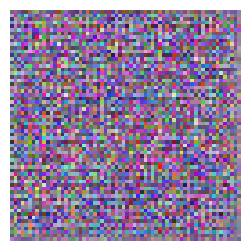

In [23]:
# Visualizar una imagen
fig = plt.figure(figsize=(3,3))
plt.imshow(dummy_img.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

#### Optimización

Utilizar `torch.optim.Adam` para optimizar los parámetros del discriminador y del generador.     

✍   
Agregar los siguientes argumentos en la clase:

*   `params` Parámetros a optimizar.  
*   `lr` factor de aprendizaje. Igualar lr=0.0002
*   `betas` Establecer betas=(0.5,0.999)


In [24]:
# Definir hiperparámetros del optimizador
lr = 0.0002
betas = (0.5, 0.999)

generator_opt = torch.optim.Adam(params=generator.parameters(), lr=lr, betas=betas)
discriminator_opt = torch.optim.Adam(params=discriminator.parameters(), lr=lr, betas=betas)

#### Función de costo del discriminador

In [25]:
def discriminator_loss(real_out, fake_out,smoothing_factor = 0.9):
    '''
    Input:
    - real_out. Predicciones de imágenes reales
    - fake_ out. Predicciones de imágenes falsas
    -smoothing_factor. Factor de ruido en la entrada del discriminador
    '''
    real_loss = F.binary_cross_entropy(real_out, torch.ones_like(real_out)*smoothing_factor)
    fake_loss = F.binary_cross_entropy(fake_out, torch.zeros_like(fake_out))
    total_loss = (real_loss + fake_loss)/2
    return total_loss

In [26]:
def generator_loss(fake_out):
    '''
    Input:
    - fake_ out. Predicciones de imágenes falsas
    '''
    gen_loss = F.binary_cross_entropy(fake_out, torch.ones_like(fake_out))
    return gen_loss

## 5. Entrenamiento

In [27]:
def generate_noise_vectors(sample_size,latent_dim):
    '''
    Input:
    - sample_size. Tamaño de las muestras
    - latent_dim. Dimesión del vector
    '''
    noise_vector = torch.randn(sample_size,latent_dim)
    return noise_vector

In [28]:
# Generar vectores para imágenes de prueba
num_images_test = 25
torch.manual_seed(42)
noise_test = generate_noise_vectors(num_images_test,LATENT_DIM)
noise_test.shape

torch.Size([25, 128])

In [31]:
def show_grid(images, epoch, rows = int(math.sqrt(num_images_test))):
    num = images.size(0)
    fig = plt.figure(figsize= (5,5))

    for i in range(1, num+1):
        fig.add_subplot(rows, rows, i)
        plt.axis('off')
        plt.imshow(images[i-1].squeeze().permute(1, 2, 0))

    plt.savefig('./image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return

✍  
Agregar número de épocas (`EPOCHS`) para el entrenamiento

In [37]:
EPOCHS = 50

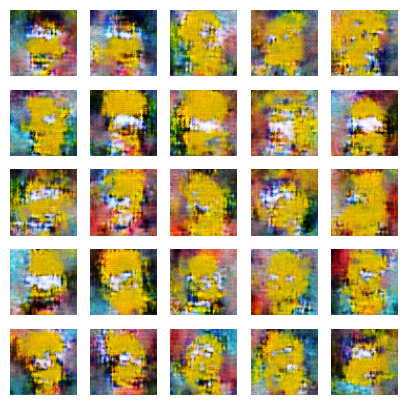

Epoch: 46
--------
Train Epoch: 46 [0/577 (0%)]	G-Loss: 4.493011 D-Loss: 0.178870
Epoch: 47
--------
Train Epoch: 47 [0/577 (0%)]	G-Loss: 4.678504 D-Loss: 0.691963
Epoch: 48
--------
Train Epoch: 48 [0/577 (0%)]	G-Loss: 4.083748 D-Loss: 0.231229
Epoch: 49
--------
Train Epoch: 49 [0/577 (0%)]	G-Loss: 5.912640 D-Loss: 0.274031


In [38]:
# training mode
generator.train()
discriminator.train()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    for batch, (real_images) in enumerate(train_dataloader):
        ## ---------------------- Train Discriminator ----------------------
        for i in range(0,3):
            # train the discriminator
            discriminator_opt.zero_grad()
            cur_batch_size = len(real_images)
            real_images = real_images.to(device)
            noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
            fake_images = generator(noise)
            # Entrenamiento en datos reales
            real_preds = discriminator(real_images)
            # Entrenamiento en datos falsos
            fake_preds = discriminator(fake_images.detach())
            disc_loss = discriminator_loss(real_preds, fake_preds,0.9)
            disc_loss.backward()
            # Optimizer step
            discriminator_opt.step()

        ## ---------------------- Train Generator ----------------------
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        generated_images = generator(noise)
        # train the generator
        generator_opt.zero_grad()
        # Generación de imagenes
        fake_preds = discriminator(generated_images)
        gen_loss = generator_loss(fake_preds)
        gen_loss.backward()
        generator_opt.step()

        if batch % 128 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tG-Loss: {:.6f} D-Loss: {:.6f}'.format(
                epoch, batch * len(real_images), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), gen_loss.item(), disc_loss.item()))


    #show the test images every 10 epochs
    if epoch%5 ==0:
        display.clear_output(wait=True)
        test_imgs = generator(noise_test.to(device)).detach()
        test_imgs = test_imgs.cpu()
        show_grid(test_imgs,epoch)


In [39]:
images = list()
filenames = glob.glob('./image*.png')
filenames = sorted(filenames)
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./dcgan_simpson.gif', images)

<ipython-input-39-45c0622fa92a>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
